In [9]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.image import new_img_like
import pandas as pd
import nibabel as nib
import seaborn as sns
from nilearn import plotting, surface
from rsatoolbox.inference import eval_fixed
from rsatoolbox.model import ModelFixed
from rsatoolbox.rdm import RDMs
from glob import glob
from rsatoolbox.util.searchlight import get_volume_searchlight, get_searchlight_RDMs, evaluate_models_searchlight
from bids.layout import BIDSLayout
import os
from matplotlib.ticker import StrMethodFormatter
from datetime import datetime


In [10]:
def upper_tri(RDM):
    """upper_tri returns the upper triangular index of an RDM

    Args:
        RDM 2Darray: squareform RDM

    Returns:
        1D array: upper triangular vector of the RDM
    """
    # returns the upper triangle
    m = RDM.shape[0]
    r, c = np.triu_indices(m, 1)
    return RDM[r, c]

import matplotlib.colors
def RDMcolormapObject(direction=1):
    """
    Returns a matplotlib color map object for RSA and brain plotting
    """
    if direction == 0:
        cs = ['yellow', 'red', 'gray', 'turquoise', 'blue']
    elif direction == 1:
        cs = ['blue', 'turquoise', 'gray', 'red', 'yellow']
    else:
        raise ValueError('Direction needs to be 0 or 1')
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", cs)
    return cmap

In [11]:
ds_path = '/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids'

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(ds_path, derivatives = True)

layout.add_derivatives(os.path.join(ds_path, "results", "first-level"))

# lets plot the voxels above the 99th percentile

save_path = "/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/Figures"  # Change this to your desired path

# Get today's date and convert it to a string in the format YYYYMMDD
today_str = datetime.today().strftime('%Y%m%d')


In [12]:
# create masks 
sID = ['01']

# load one image to get the dimensions and make the mask
tmp_img = nib.load(f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/first-level/sub-{sID[0]}/sub-{sID[0]}_task-gesture_desc-Ab1_effect_size.nii.gz')

# we infer the mask by looking at non-nan voxels
mask = ~np.isnan(tmp_img.get_fdata())
x, y, z = tmp_img.get_fdata().shape

lh_pial_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sub-{sID[0]}/anat/sub-{sID[0]}_acq-mprage_hemi-L_pial.surf.gii'
lh_pial_gii = nib.load(lh_pial_file)
lh_pial_coords = lh_pial_gii.darrays[0].data
lh_pial_faces = lh_pial_gii.darrays[1].data
lh_pial_mesh = (lh_pial_coords, lh_pial_faces)
    
# Load the inflated surface in Gifti format
lh_inflated_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sub-{sID[0]}/anat/sub-{sID[0]}_acq-mprage_hemi-L_inflated.surf.gii'
lh_inflated_gii = nib.load(lh_inflated_file)
lh_inflated_coords = lh_inflated_gii.darrays[0].data
lh_inflated_faces = lh_inflated_gii.darrays[1].data
lh_inflated_mesh = (lh_inflated_coords, lh_inflated_faces)

# Define the path to the subject’s curvature file
lh_bg_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sourcedata/freesurfer/sub-{sID[0]}/surf/lh.avg_curv'
lh_bg_data = nib.freesurfer.read_morph_data(lh_bg_file)

# Load label file, and find S1 and M1
label_file = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/derivatives/fmriprep/sourcedata/freesurfer/sub-{sID[0]}/label/lh.BA_exvivo.thresh.annot'
label_data = surface.load_surf_data(label_file)
label_data = np.array(label_data)

# primary Broca
index_b = np.isin(label_data, [9])

# Assign 1 to elements in the mask, and 0 to elements outside the mask
label_data[index_b] = 2
label_data[~(index_b)] = 0

# saving here incase you want to use for Joern's mask
mask_path = f'/Users/jonathantsay/GestureContextPilot/CodeForExp/JT_Semantomotor/data/bids/results/transformed-masks/sub-{sID[0]}/sub-{sID[0]}_transformed_joern_handmask.nii.gz'
mask_img = nib.load(mask_path)
mask_id = 1
mask_data = mask_img.get_fdata()
mask_data[(mask_data > mask_id) | (mask_data < mask_id)] = 0
mask_data[mask_data == mask_id] = 1 
mask_img_mod = nib.Nifti1Image(mask_data, affine = mask_img.affine, header= mask_img.header)
mask_texture = surface.vol_to_surf(mask_img_mod, lh_pial_mesh, interpolation = 'linear', radius = 1)
mask_texture[mask_texture > 0.5] = 1
mask_texture[mask_texture <= 0.5] = 0
    
mask_comb = np.maximum(mask_texture, label_data)


In [14]:
upper_tri(my_rdm)

array([0. , 0.5, 0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. , 0.5, 0.5,
       0.5, 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. , 0. , 1. , 1. , 0.5, 0.5,
       1. , 1. , 0.5, 0.5, 1. , 1. , 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0. ,
       0.5, 0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 0.5, 1. , 1. , 0. ,
       1. , 1. , 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5,
       0. ])

Finding searchlights...: 100%|██████████| 433526/433526 [02:28<00:00, 2912.28it/s]


Found 433526 searchlights


Calculating RDMs...:   0%|          | 0/100 [00:00<?, ?it/s]/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/rsatoolbox/data/computations.py:36: RuntimeWarning: invalid value encountered in multiply
  average = np.nan * np.empty(
Calculating RDMs...: 100%|██████████| 100/100 [03:59<00:00,  2.40s/it]


[[-1.   0.   0.5  0.5  0.5  0.5  1.   1.   0.5  0.5  1.   1. ]
 [ 0.  -1.   0.5  0.5  0.5  0.5  1.   1.   0.5  0.5  1.   1. ]
 [ 0.5  0.5 -1.   0.   1.   1.   0.5  0.5  1.   1.   0.5  0.5]
 [ 0.5  0.5  0.  -1.   1.   1.   0.5  0.5  1.   1.   0.5  0.5]
 [ 0.5  0.5  1.   1.  -1.   0.   0.5  0.5  0.5  0.5  1.   1. ]
 [ 0.5  0.5  1.   1.   0.  -1.   0.5  0.5  0.5  0.5  1.   1. ]
 [ 1.   1.   0.5  0.5  0.5  0.5 -1.   0.   1.   1.   0.5  0.5]
 [ 1.   1.   0.5  0.5  0.5  0.5  0.  -1.   1.   1.   0.5  0.5]
 [ 0.5  0.5  1.   1.   0.5  0.5  1.   1.  -1.   0.   0.5  0.5]
 [ 0.5  0.5  1.   1.   0.5  0.5  1.   1.   0.  -1.   0.5  0.5]
 [ 1.   1.   0.5  0.5  1.   1.   0.5  0.5  0.5  0.5 -1.   0. ]
 [ 1.   1.   0.5  0.5  1.   1.   0.5  0.5  0.5  0.5  0.  -1. ]]


Evaluating models for each searchlight:   0%|          | 0/433526 [00:00<?, ?it/s]/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/rsatoolbox/util/inference_util.py:125: UserWarning: Noise ceiling for tau based on averaged ranks!
  warnings.warn('Noise ceiling for tau based on averaged ranks!')
/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/rsatoolbox/util/inference_util.py:125: UserWarning: Noise ceiling for tau based on averaged ranks!
  warnings.warn('Noise ceiling for tau based on averaged ranks!')
/Users/jonathantsay/anaconda3/envs/WeatherModel/lib/python3.11/site-packages/rsatoolbox/util/inference_util.py:125: UserWarning: Noise ceiling for tau based on averaged ranks!
  warnings.warn('Noise ceiling for tau based on averaged ranks!')
Evaluating models for each searchlight: 100%|██████████| 433526/433526 [02:15<00:00, 3189.83it/s]
/var/folders/qf/gprldtv546n8mtt3q8_9_rmm0000gn/T/ipykernel_96800/3278932948.py:126: Deprecatio

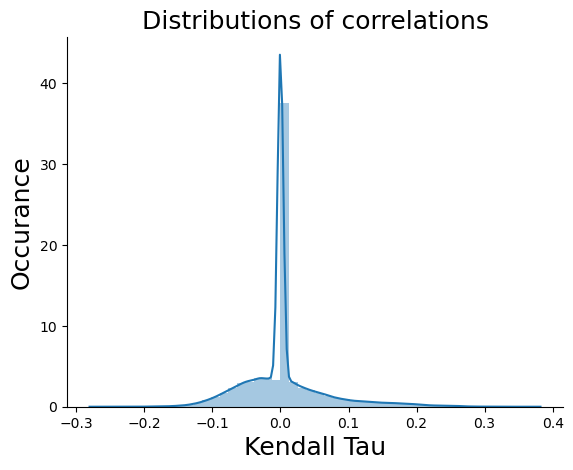

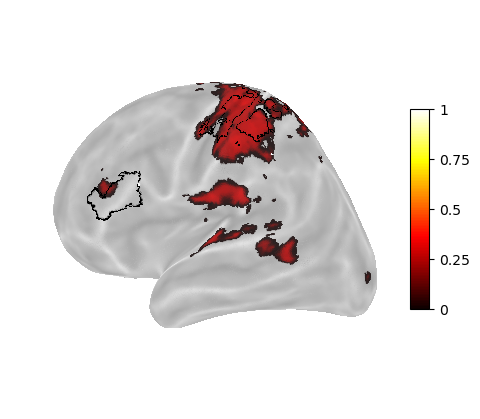

In [13]:
# Get searchlight centers and neighbors
centers, neighbors = get_volume_searchlight(mask, radius=5, threshold=0.5)

# Define contrast list
contrast_list = np.array([
    'L1', 'N1', 'Ac1', 'Ab1',
    'L2', 'N2', 'Ac2', 'Ab2',
    'L3', 'N3', 'Ac3', 'Ab3'
])

# Define number of conditions and voxels
nCond = 12
x, y, z = mask.shape
nVox = x * y * z

# Initialize data array
my_counter = 0
data = np.zeros((nCond, x, y, z))

# Load data for each contrast
for i, contrast in enumerate(contrast_list):
    filenames = layout.get(
        subject=sID[0], 
        desc=contrast, 
        suffix='size', 
        extension='.nii.gz', 
        return_type='filename'
    )
    
    # Filter filenames
    filtered_list = [s for s in filenames if 'run' not in s and 'threshed' not in s]
    
    # Load data if filenames are found
    if filtered_list:
        data[my_counter] = nib.load(filtered_list[0]).get_fdata()
        my_counter += 1
    else:
        print(f"No filenames found for contrast {contrast}. Skipping.")

# Check if all contrasts were loaded
if my_counter != nCond:
    print("Warning: Not all contrasts were loaded. Please check the input data.")

# Reshape data for searchlight analysis
data_2d = data.reshape([data.shape[0], -1])
data_2d = np.nan_to_num(data_2d)
image_value = np.arange(len(data_2d))

# Calculate searchlight RDMs
SL_RDM = get_searchlight_RDMs(data_2d, centers, neighbors, image_value, method='mahalanobis')

# Define model list
# model_list = [
#     'gesture_only', 'ChaCon',
#     'let_only', 'num_only', 
#     'act_only', 'abs_only'
# ]

model_list = ['GestChaCon']

# Evaluate each model
for my_model_name in model_list: 
    # Initialize RDM
    my_rdm = np.ones((12, 12))
    np.fill_diagonal(my_rdm, 0)
    
    if my_model_name == "gesture_only":

        my_rdm[0:4, 0:4] = 0
        my_rdm[4:8, 4:8] = 0
        my_rdm[8:12, 8:12] = 0
    
    elif my_model_name == "let_only":
    
        my_rdm[0, np.r_[0, 4, 8]] = 0
        my_rdm[4, np.r_[0, 4, 8]] = 0
        my_rdm[8, np.r_[0, 4, 8]] = 0
    
    elif my_model_name == "num_only":
    
        my_rdm[1, np.r_[1, 5, 9]] = 0
        my_rdm[5, np.r_[1, 5, 9]] = 0
        my_rdm[9, np.r_[1, 5, 9]] = 0

    elif my_model_name == "act_only":
    
        my_rdm[2, np.r_[2, 6, 10]] = 0
        my_rdm[6, np.r_[2, 6, 10]] = 0
        my_rdm[10, np.r_[2, 6, 10]] = 0
    
    elif my_model_name == "abs_only":
    
        my_rdm[3, np.r_[3, 7, 11]] = 0
        my_rdm[7, np.r_[3, 7, 11]] = 0
        my_rdm[11, np.r_[3, 7, 11]] = 0
    
    elif my_model_name == 'ChaCon':

        my_rdm[2:4, np.r_[2:4, 6:8, 10:12]] = 0
        my_rdm[6:8, np.r_[2:4, 6:8, 10:12]] = 0
        my_rdm[10:12, np.r_[2:4, 6:8, 10:12]] = 0
        my_rdm[0:2, np.r_[0:2, 4:6, 8:10]] = 0
        my_rdm[4:6, np.r_[0:2, 4:6, 8:10]] = 0
        my_rdm[8:10, np.r_[0:2, 4:6, 8:10]] = 0
    
    elif my_model_name == 'GestChaCon':

        my_rdm[0:4, 0:4] += -0.5
        my_rdm[4:8, 4:8] += -0.5
        my_rdm[8:12, 8:12] += -0.5
        
        my_rdm[2:4, np.r_[2:4, 6:8, 10:12]] += -0.5
        my_rdm[6:8, np.r_[2:4, 6:8, 10:12]] += -0.5
        my_rdm[10:12, np.r_[2:4, 6:8, 10:12]] += -0.5
        my_rdm[0:2, np.r_[0:2, 4:6, 8:10]] += -0.5
        my_rdm[4:6, np.r_[0:2, 4:6, 8:10]] += -0.5
        my_rdm[8:10, np.r_[0:2, 4:6, 8:10]] += -0.5
    
    print(my_rdm)
    
    # Initialize model
    my_model = ModelFixed(my_model_name, upper_tri(my_rdm)) 
    
    # Evaluate model
    eval_results = evaluate_models_searchlight(SL_RDM, my_model, eval_fixed, method='tau-a', n_jobs=3)
    eval_score = [float(e.evaluations) for e in eval_results]
    
    # Plot results
    sns.distplot(eval_score)
    plt.title('Distributions of correlations', size=18)
    plt.ylabel('Occurance', size=18)
    plt.xlabel('Kendall Tau', size=18)
    sns.despine()
    plt.show()
    
    # Reshape results back to brain space
    RDM_brain = np.zeros([x * y * z])
    RDM_brain[list(SL_RDM.rdm_descriptors['voxel_index'])] = eval_score
    RDM_brain = RDM_brain.reshape([x, y, z])
    
    # Apply threshold
    threshold = np.percentile(eval_score, 99)
    RDM_brain[RDM_brain < threshold] = 0

    # Create Nifti image
    RDM_brain_img = nib.Nifti1Image(RDM_brain, affine=tmp_img.affine, header=tmp_img.header)

    # Map to surface and plot
    lh_texture = surface.vol_to_surf(RDM_brain_img, lh_pial_mesh, interpolation='linear', radius=1)
    figure = plotting.plot_surf_stat_map(
        lh_inflated_mesh, lh_texture, view='lateral', hemi='left', 
        colorbar=True, threshold=0.00001, bg_map=lh_bg_data, 
        bg_on_data=True, alpha=0.5, darkness=0.5, vmax=1, 
        symmetric_cbar=False, title_fontsize='x-large', 
        colorbar_fontsize='large', colorbar_height=0.6, 
        colorbar_tick_length=0.1,
    )

    # Add contours for ROIs
    plotting.plot_surf_contours(
        lh_inflated_mesh, roi_map=mask_comb, colors=['w', 'black', 'black'], figure=figure,
    )

    # Save figure
    today_str = datetime.now().strftime("%Y-%m-%d")
    filename = os.path.join(save_path, f"sub-{sID[0]}_RDM-{my_model_name}_view-lateral_{today_str}.jpeg")
    plt.savefig(filename, format='jpeg', dpi=300)
    plt.show()


In [8]:
# Define model list

model_list = [
    'gesture_only', 'ChaCon',
    'let_only', 'num_only', 
    'act_only', 'abs_only'
]

# Evaluate each model
for my_model_name in model_list: 
    # Initialize RDM
    my_rdm = np.ones((12, 12))
    np.fill_diagonal(my_rdm, 0)
    
    if my_model_name == "gesture_only":

        my_rdm[0:4, 0:4] = 0
        my_rdm[4:8, 4:8] = 0
        my_rdm[8:12, 8:12] = 0
    
    elif my_model_name == "let_only":
    
        my_rdm[0, np.r_[0, 4, 8]] = 0
        my_rdm[4, np.r_[0, 4, 8]] = 0
        my_rdm[8, np.r_[0, 4, 8]] = 0
    
    elif my_model_name == "num_only":
    
        my_rdm[1, np.r_[1, 5, 9]] = 0
        my_rdm[5, np.r_[1, 5, 9]] = 0
        my_rdm[9, np.r_[1, 5, 9]] = 0

    elif my_model_name == "act_only":
    
        my_rdm[2, np.r_[2, 6, 10]] = 0
        my_rdm[6, np.r_[2, 6, 10]] = 0
        my_rdm[10, np.r_[2, 6, 10]] = 0
    
    elif my_model_name == "abs_only":
    
        my_rdm[3, np.r_[3, 7, 11]] = 0
        my_rdm[7, np.r_[3, 7, 11]] = 0
        my_rdm[11, np.r_[3, 7, 11]] = 0
    
    elif my_model_name == 'ChaCon':

        my_rdm[2:4, np.r_[2:4, 6:8, 10:12]] = 0
        my_rdm[6:8, np.r_[2:4, 6:8, 10:12]] = 0
        my_rdm[10:12, np.r_[2:4, 6:8, 10:12]] = 0
        my_rdm[0:2, np.r_[0:2, 4:6, 8:10]] = 0
        my_rdm[4:6, np.r_[0:2, 4:6, 8:10]] = 0
        my_rdm[8:10, np.r_[0:2, 4:6, 8:10]] = 0
    
    print(my_rdm)
    
    # Visualize and save the RDM
    rsatoolbox.vis.show_rdm(my_rdm, vmin=0, n_row=1, figsize=(3.5,2.5), cmap='plasma')
    ax = plt.gca()
    im = ax.get_images()[0]
    cbar_obj = plt.colorbar(im)
    cbar_obj.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    filename = f"{save_path}/my_rdm_{my_model_name}_{today_str}.jpeg"
    plt.savefig(filename, format='jpeg', dpi=300)
    plt.show()
    
    
    

[[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]]


AttributeError: 'numpy.ndarray' object has no attribute 'n_cond'